In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from IPython.display import Markdown as mdp
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import pandas as pd
import re
import scipy.stats
import statsmodels.api as sm
import sys
import xarray as xr
sys.path.append('../../lib')
from regimeshifts import ews

In [2]:
## Reading labels
rec_labels = pd.read_csv('output/sel_rec_labels.csv',index_col=0)

In [3]:
data_path = 'output/sel_records_data.csv'
md_path = 'output/sel_records_metadata.csv'
sel_rec = pd.read_csv(data_path, index_col=0)
sel_rec_md = pd.read_csv(md_path, index_col=0)
data_path = '../../../datasets/bivalve-sclerochronologies/'
nfs_ds = pd.read_csv(data_path+sel_rec_md.loc['SPNF_PP_GD']['file'],index_col=0)

### AR(1) trends before 1920

In [4]:
longrec_path = 'output/sel_long_records_metadata.csv'
long_recs_md = pd.read_csv(longrec_path, index_col=0)
long_recs = list(long_recs_md.index.values)
ews_1920 = pd.read_csv('output/pvalues_1750_1920.csv',index_col=0)

In [5]:
rob_stats1920 = pd.DataFrame(index=long_recs,columns=['median','perc_positive'])
for i,rec_id in enumerate(rob_stats1920.index):
    kc_df = pd.read_csv(f'output/rob_{rec_id}_1750_1920.csv', index_col=0)
     ## Filtering out wLs smaller than 30
    kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=30]]
    ## Filtering out bWs smaller than 25 years
    kc_df = kc_df[kc_df.index>=25]
    kc_data = kc_df.to_numpy().flatten()
    rob_stats1920.loc[rec_id,'median'] = np.median(kc_data)
    rob_stats1920.loc[rec_id,'perc_positive'] = len(kc_data[kc_data>0])/len(kc_data)
    rob_stats1920.loc[rec_id,'perc_larg035'] = len(kc_data[kc_data>=0.35])/len(kc_data)
sort_by_median = rob_stats1920.sort_values(by='median',ascending=False)

In [6]:
### Reading percentage of significant combinations
path = 'output/significant_combinations/'
rob_stats1920['perc_signif'] = np.nan
for i,rec_id in enumerate(rob_stats1920.index):
    bW_vs = np.load(path+f'bW_vs_{rec_id}_bef1920.npy')
    wL_vs = np.load(path+f'wL_vs_{rec_id}_bef1920.npy')
    pvals = np.load(path+f'par1_{rec_id}_bef1920.npy')
    pvals_signif = np.where(pvals<=0.1) ## Significance set to p<=0.1
    sig_df = pd.DataFrame(data=pvals,index=bW_vs,columns=wL_vs)
    sig_df  = sig_df[sig_df.index>=15]
    perc_sig = np.round(sig_df[sig_df<0.1].count().sum() / sig_df.size,2)
    perc_positive = np.round(sig_df[sig_df<0.1].count().sum() / sig_df.size,2)
    rob_stats1920.loc[rec_id,'perc_signif'] = perc_sig

In [7]:
signif_rec = rob_stats1920[rob_stats1920.perc_signif>0.1].sort_values(by='perc_signif',ascending=False).index
nonsig = rob_stats1920[rob_stats1920.perc_signif<=0.1].sort_values(by='perc_positive',ascending=False).index
nonsig = ['NIS_DR_d18O','NIS_DR_d13C','BL_IR','TP_DR_d13C','NIS_PB_NEars', 'BS_MM_NE', ## Visual arrangement for non-significant records
          'Faroe_FWB_NEars', 'Norw_HH_RCS', 'SWI_MM_d18O','SWI_MM_HGF','TP_DR_d18O']
long_recs = list(signif_rec) + list(nonsig)

In [8]:
def format_label(label):
    if len(label.split('$')) > 1:
        tof_label = label.split('$')[0]
        isot_expr = label.split('$')[1]
        trail = label.split('$')[-1]
    else:
        tof_label = label
    if len(label.split(' ')[-1]) == 1:
        flabel = re.sub(" ", "\n", tof_label,count=len(label.split(' '))-2)
    else:
        flabel = tof_label.replace(' ', '\n')
    if len(label.split('$')) > 1:
        flabel = flabel + '$' + isot_expr + '$' + trail
    return flabel

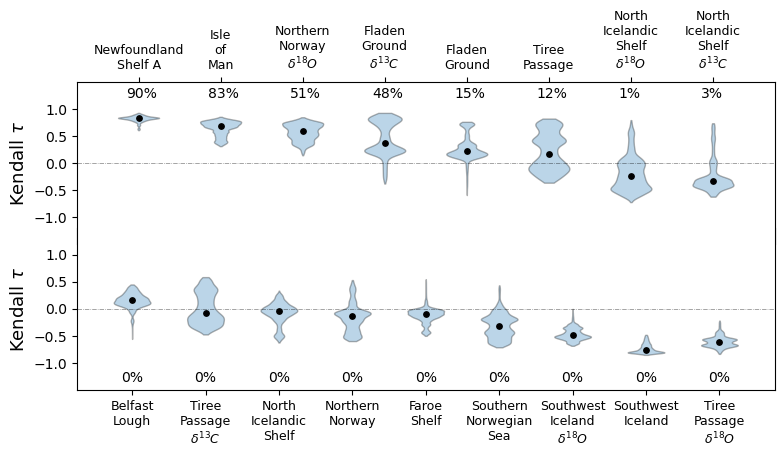

In [9]:
lab_position = ['top','bottom']
fig, axs = plt.subplots(2,1,figsize=(len(long_recs)//2 +1,4),
                        gridspec_kw={'hspace': -0.1},facecolor='white')
medians_all = pd.Series(index=long_recs)
for j in [0,1]:
    labels = []
    rob_dist = []
    medians = []
    start = 0 if j==0 else len(long_recs)//2 + 1
    end = -1 if j==1 else len(long_recs)//2 + 1
    if j == 0:
        slice_rec = long_recs[0:len(long_recs)//2 ]
    else:
        slice_rec = long_recs[len(long_recs)//2::]
    for i,rec_id in enumerate(slice_rec):
        color = 'tab:blue'
        kc_df = pd.read_csv(f'output/rob_{rec_id}_1750_1920.csv', index_col=0)
         ## Filtering wLs greater than 40
        kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=25]]
        kc_data = kc_df.to_numpy().flatten()
        rob_dist.append(list(kc_data))
        medians.append(np.median(kc_data))
        medians_all.loc[rec_id] = np.median(kc_data)
        label = format_label(rec_labels.loc[rec_id,'label'])
        labels.append(label)
    violin = axs[j].violinplot(rob_dist,showmeans=False, showmedians=False,showextrema=False)    
    inds = np.arange(1, len(medians) + 1)
    axs[j].scatter(inds, medians, marker='o', color='k', s=15, zorder=3)
    for i,pc in enumerate(violin['bodies']):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        loc_perc = -1.36 if j == 1 else 1.2
        perc_signif = str(int(np.round(rob_stats1920.loc[slice_rec[i],'perc_signif']*100,0)))
        axs[j].text(i+1-0.15,loc_perc,perc_signif+'%')

    axs[j].set_ylim(-1.5,1.5)
    axs[j].xaxis.set_tick_params(direction='out')
    axs[j].xaxis.set_ticks_position(lab_position[j])
    axs[j].set_xticks(np.arange(1, len(labels) + 1))
    axs[j].set_xticklabels(labels,fontsize=9)
    axs[j].set_xlim(0.25, len(labels) + 0.75)
    axs[j].set_ylabel(r'Kendall $\tau$', fontsize=13)
    axs[j].set_yticks([-1.0,-0.5,0,0.5,1.0]);
    axs[j].axhline(0,color='k',linestyle='-.',linewidth=0.5,alpha=0.5)
axs[1].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
fig.savefig(f'img/AR1_rob_before_1920_long_rec.pdf',dpi=500, bbox_inches='tight')

In [10]:
def rec_type(row):
    if '18O' in row.name:
        return 'oxygen'
    elif '13C' in row.name:
        return 'carbon'
    else:
        return 'growth'

In [11]:
coords1920 = long_recs_md.loc[long_recs]
coords1920['Latitude'] = (coords1920['Northernmost_lat']+coords1920['Southernmost_lat'])/2
coords1920['Longitude'] = (coords1920['Westernmost_lon']+coords1920['Easternmost_lon'])/2
coords1920 = coords1920[['Latitude','Longitude']]
coords1920[['median','perc_positive','perc_larg035','perc_signif']] = rob_stats1920
coords1920['ar1'] = ews_1920['kc']
coords1920['pvalue'] = ews_1920['pvalue']
coords1920['type'] = coords1920.apply(lambda x: rec_type(x),axis=1)
coords1920.to_csv('output/pvalues_coords_1750_1920.csv')

In [12]:
def get_new_coors_proj(grouped_coors_row,coords_df,proj, radius=1.5,init_angle=-20,trim_angle=10,full_angle=220):
    """
    Estimates the new coordinates for a group of records with the same coordinates
    Returns the new coordinates in the coordinate system of the received projection
    """
    res_ang = full_angle - (2 * trim_angle) # 
    n_rec = grouped_coors_row['count'] 
    part_angle = res_ang/(n_rec + 1) # Resulting angle after dividing by the number of records
    group_df = coords_df.loc[grouped_coors_row['record']] ## Retrieving dataframe
    proj_cart = ccrs.PlateCarree() ## Cartesian coordinate system
    x,y = proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean(),src_crs=proj_cart)
    ## One degree of latitude in the projection coordinates
    one_deg_lat_proj = y - proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean()+1,src_crs=proj_cart)[1]
    group_df['x'] = x
    group_df['y'] = y
    y_plus = []
    x_plus = []    
    
    for i in range(1,n_rec+1):        
        y_plus.append(np.sin(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
        x_plus.append(np.cos(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
    group_df.y += y_plus
    group_df.x += x_plus
    return group_df

/tmp/ipykernel_14132/3420675451.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lat'] = [-1,-1.2]
/tmp/ipykernel_14132/3420675451.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signif_rec['offset_lon'] = [-1.5,0.3]


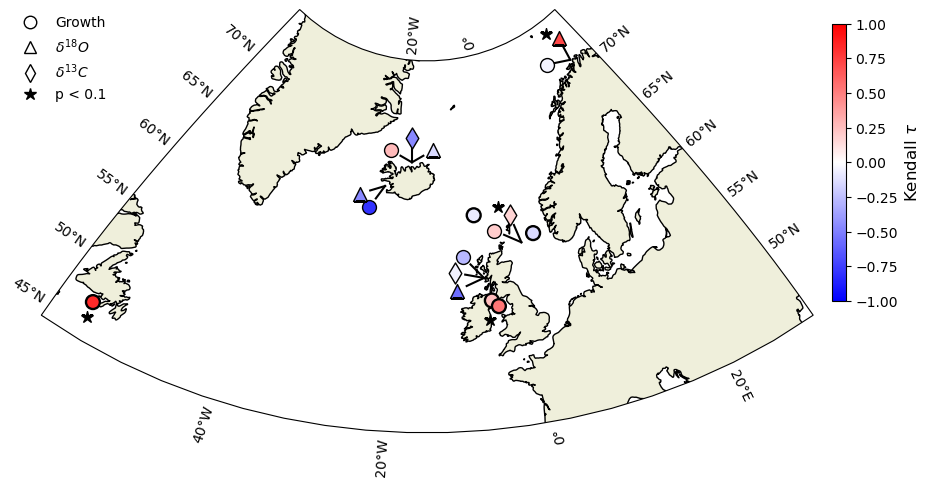

In [13]:
biv_ews = coords1920
lons = [-60,30]
lats = [44,75]
proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                               central_latitude=lats[0]+(lats[1]-lats[0])/2)
n = 20
aoi = mpath.Path(
    list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
    list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
    list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
    list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
)
plt.close()
fig = plt.figure(figsize=(12,8),facecolor='white')
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
#ax2 = fig.add_subplot(1, 2, 2, projection=proj)
for ax in [ax1]:
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())    
    ax.add_feature(cfeature.LAND,zorder=2)
    ax.coastlines(resolution='50m',zorder=2)
    gl = ax.gridlines(draw_labels=True,linewidth=0.00001, linestyle='--',alpha=0)
    gl.top_labels = False
    gl.right_labels = False
#mapc = ds.ar1.plot(ax=ax1,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='bwr',add_colorbar=False)
#ds.variance.plot(ax=ax2,transform=ccrs.PlateCarree(),vmin=-1,vmax=1,cmap='coolwarm',add_colorbar=False)#,cbar_kwargs={'shrink':0.7})

#cbar = plt.colorbar(mapc, ax=[ax1],pad=0.07,shrink=shrink_bar)
#ax1.set_title('AR(1)', fontsize=12)
#ax2.set_title('Variance', fontsize=12)
#cbar.ax.set_ylabel(r'Kendall $\tau$', fontsize=12);
#fig.suptitle(title,x=0.45,y=0.95,weight='bold');


### Plotting the Kendall values from the bivalve records on top
### Grouping coordinates
coors_yr_df = biv_ews.reset_index()
coors_yr_df.rename(columns={'index':'record'}, inplace=True)
coors_yr_gr = coors_yr_df.groupby([coors_yr_df['Latitude'].apply(lambda x: round(x*2)/2),coors_yr_df['Longitude'].apply(lambda x: round(x*2)/2)]).agg(list)
coors_yr_gr['count'] = coors_yr_gr.record.apply(lambda x: len(x))
unique_yr_coors = coors_yr_gr[coors_yr_gr['count']==1].record.apply(lambda x: x[0]).values
yr_unique_coors = biv_ews.loc[unique_yr_coors]
indicator_label = {'ar1':'AR(1)','var':'Variance'}
markers = {'growth':'o','oxygen':'^','carbon':'d'}
markersize = {'growth':100,'oxygen':100,'carbon':115}
markerlabels = {'Growth':'o',r'$\delta ^{18}O$':'^',r'$\delta ^{13}C$':'d'}
for indicator,ax in zip(['ar1'],[ax1]):
    ## Records with repeated coordinates
    initial_angles = {(56.5, -6.5):-90,(59.0, 0.5):-120,(59.5, 0.5):90,(66.5, -18.0):140,
                      (71.0, 24.0):-145,(47.0, -56.5):50,(64.5, -23.0):-30}
    full_angles = {(56.5, -6.5):160,(59.0, 0.5):150,(59.5, 0.5):110,(66.5, -18.0):260,
                   (71.0, 24.0):240,(47.0, -56.5):150,(64.5, -23.0):130}
    radii = {(56.5, -6.5):2.5,(59.0, 0.5):2.5,(59.5, 0.5):1,(66.5, -18.0):2,
             (71.0, 24.0):2.5,(47.0, -56.5):2.5,(64.5, -23.0):2.2}
    origin_radii = {(56.5, -6.5):0,(59.0, 0.5):0,(59.5, 0.5):0.7,(66.5, -18.0):0,
                    (71.0, 24.0):0,(47.0, -56.5):0,(64.5, -23.0):0}
    ## Parameters for significant records
    plus_radii = {(56.5, -6.5):1.1,(59.0, 0.5):1.1,(66.5, -18.0):2.7,(71.0, 24.0):1.1,(47.0, -56.5):1.2}
    plus_initangle = {(56.5, -6.5):0,(59.0, 0.5):10,(66.5, -18.0):-10,(71.0, 24.0):15,(47.0, -56.5):0}
    for idx,row in coors_yr_gr[coors_yr_gr['count']>1].iterrows():
        new_coors = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])
        for type_rec,marker in markers.items():
            coors_type = new_coors[new_coors.type==type_rec]
            if len(coors_type) > 0:
                ax.scatter(x=coors_type.x, y=coors_type.y, s=markersize[type_rec],linewidth=1, marker=marker,
                       c=coors_type[indicator], cmap='bwr',vmin=-1,vmax=1,
                       edgecolors='k',zorder=2)
        ### Adding a star to records with significant trends            
        if len(new_coors[new_coors.perc_signif.round(2)>=0.2])>0:
            signif_rec_id = new_coors[new_coors.perc_signif.round(2)>=0.2].index.values
            new_coors_signif = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]+plus_radii[idx],init_angle=initial_angles[idx]+plus_initangle[idx],full_angle=full_angles[idx])
            signif_rec = new_coors_signif.loc[[rec for rec in row.record if rec in signif_rec_id]]
            ax.plot(signif_rec.x, signif_rec.y, "*",color='k',markeredgecolor='k', markersize=9)
    
        new_coors_lines = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]-0.9,init_angle=initial_angles[idx],full_angle=full_angles[idx])
        new_coors_origin = get_new_coors_proj(row,biv_ews,proj,radius=origin_radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])        
        ax.plot([new_coors_lines.x, new_coors_origin.x], [new_coors_lines.y, new_coors_origin.y],color='k')
    ## Records with unique coordinates
    yr_unique_coors = yr_unique_coors.sort_values(by='ar1')
    cm = ax.scatter(x=yr_unique_coors.Longitude, y=yr_unique_coors.Latitude, s=100,linewidth=1.7, 
               c=yr_unique_coors[indicator], cmap='bwr',vmin=-1,vmax=1,transform=ccrs.PlateCarree(),
               edgecolors='k',zorder=2)
    cbar = plt.colorbar(cm, ax=[ax1],pad=0.02,shrink=0.45)
    cbar.ax.set_ylabel(r'Kendall $\tau$', fontsize=12);
    ## Significant records
    signif_rec = yr_unique_coors[yr_unique_coors.perc_signif.round(2)>=0.2]
    signif_rec['offset_lat'] = [-1,-1.2]
    signif_rec['offset_lon'] = [-1.5,0.3]
    ax.plot(signif_rec.Longitude+signif_rec['offset_lon'], signif_rec.Latitude+signif_rec['offset_lat'],"*",
            color='k',markeredgecolor='k', markersize=9,transform=ccrs.PlateCarree())
    ax.set_extent([lons[0], lons[1], lats[0], lats[1]])
    # Legend
    for label,marker in markerlabels.items():
        ax.plot(-180,0,marker=marker,markersize=9,color='white',markeredgecolor='k',transform=ccrs.PlateCarree(),label=label)
    ax.plot(-180,0,"*",color='k',markeredgecolor='k', markersize=9,transform=ccrs.PlateCarree(),label='p < 0.1')
    ax.legend(loc=(-0.04,0.68),frameon=False)
fig.savefig(f'img/AR1_map_before_1920.pdf',dpi=500, bbox_inches='tight')
plt.show()

### Lambda trends before 1920

In [14]:
rob_stats1920 = pd.DataFrame(index=long_recs,columns=['median','perc_positive'])
for i,rec_id in enumerate(rob_stats1920.index):
    kc_df = pd.read_csv(f'output/rob_lambda_{rec_id}_1750_1920.csv', index_col=0)
     ## Filtering out wLs smaller than 30
    kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=30]]
    ## Filtering out bWs smaller than 25 years
    kc_df = kc_df[kc_df.index>=25]
    kc_data = kc_df.to_numpy().flatten()
    rob_stats1920.loc[rec_id,'median'] = np.median(kc_data)
    rob_stats1920.loc[rec_id,'perc_positive'] = len(kc_data[kc_data>0])/len(kc_data)
    rob_stats1920.loc[rec_id,'perc_larg035'] = len(kc_data[kc_data>=0.35])/len(kc_data)
sort_by_median = rob_stats1920.sort_values(by='median',ascending=False)

### Reading percentage of significant combinations
path = 'output/significant_combinations/'
rob_stats1920['perc_signif'] = np.nan
for i,rec_id in enumerate(rob_stats1920.index):
    bW_vs = np.load(path+f'lambda_bW_vs_{rec_id}_bef1920.npy')
    wL_vs = np.load(path+f'lambda_wL_vs_{rec_id}_bef1920.npy')
    pvals = np.load(path+f'plambda_{rec_id}_bef1920.npy')
    pvals_signif = np.where(pvals<=0.1) ## Significance set to p<=0.1
    sig_df = pd.DataFrame(data=pvals,index=bW_vs,columns=wL_vs)
    sig_df  = sig_df[sig_df.index>=15]
    perc_sig = np.round(sig_df[sig_df<0.1].count().sum() / sig_df.size,2)
    perc_positive = np.round(sig_df[sig_df<0.1].count().sum() / sig_df.size,2)
    rob_stats1920.loc[rec_id,'perc_signif'] = perc_sig

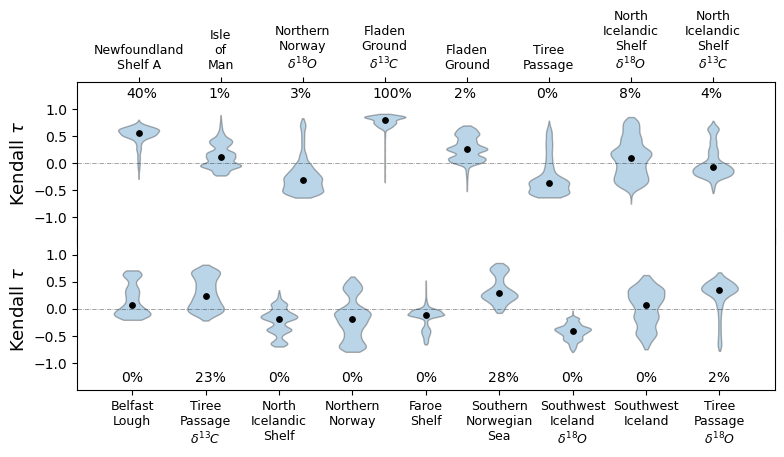

In [15]:
plt.close()
lab_position = ['top','bottom']
fig, axs = plt.subplots(2,1,figsize=(len(long_recs)//2 +1,4),
                        gridspec_kw={'hspace': -0.1},facecolor='white')
medians_all = pd.Series(index=long_recs)
for j in [0,1]:
    labels = []
    rob_dist = []
    medians = []
    start = 0 if j==0 else len(long_recs)//2 + 1
    end = -1 if j==1 else len(long_recs)//2 + 1
    if j == 0:
        slice_rec = long_recs[0:len(long_recs)//2 ]
    else:
        slice_rec = long_recs[len(long_recs)//2::]
    for i,rec_id in enumerate(slice_rec):
        color = 'tab:blue'
        kc_df = pd.read_csv(f'output/rob_lambda_{rec_id}_1750_1920.csv', index_col=0)
         ## Filtering wLs greater than 40
        kc_df = kc_df[[str(col) for col in kc_df.columns.astype('int') if col>=25]]
        kc_data = kc_df.to_numpy().flatten()
        rob_dist.append(list(kc_data))
        medians.append(np.median(kc_data))
        medians_all.loc[rec_id] = np.median(kc_data)
        label = format_label(rec_labels.loc[rec_id,'label'])
        labels.append(label)
    violin = axs[j].violinplot(rob_dist,showmeans=False, showmedians=False,showextrema=False)    
    inds = np.arange(1, len(medians) + 1)
    axs[j].scatter(inds, medians, marker='o', color='k', s=15, zorder=3)
    for i,pc in enumerate(violin['bodies']):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        loc_perc = -1.36 if j == 1 else 1.2
        perc_signif = str(int(np.round(rob_stats1920.loc[slice_rec[i],'perc_signif']*100,0)))
        axs[j].text(i+1-0.15,loc_perc,perc_signif+'%')

    axs[j].set_ylim(-1.5,1.5)
    axs[j].xaxis.set_tick_params(direction='out')
    axs[j].xaxis.set_ticks_position(lab_position[j])
    axs[j].set_xticks(np.arange(1, len(labels) + 1))
    axs[j].set_xticklabels(labels,fontsize=9)
    axs[j].set_xlim(0.25, len(labels) + 0.75)
    axs[j].set_ylabel(r'Kendall $\tau$', fontsize=13)
    axs[j].set_yticks([-1.0,-0.5,0,0.5,1.0]);
    axs[j].axhline(0,color='k',linestyle='-.',linewidth=0.5,alpha=0.5)
axs[1].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
fig.savefig(f'img/Lambda_rob_before_1920_long_rec.png',dpi=300, bbox_inches='tight')
plt.show()